<a href="https://colab.research.google.com/github/hamisB/machine-learning/blob/master/GoogleAnalytics_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital Analytics & Machine Learning 


### Authentification & Import Librairies

In [0]:
# Athentification 
from google.colab import auth
auth.authenticate_user()

In [0]:
# Import Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas_profiling as pp

### Query BigQuery Google Analytics Data

In [0]:
# Import Google Analytics Data From BigQuery
ga_data = pd.io.gbq.read_gbq(
'''
SELECT
  fullVisitorId,
  count( distinct visitId) as totalVisites, 
  CAST( TIMESTAMP_SECONDS(MIN(visitId)) AS DATE) as firstSeen, 
  CAST(TIMESTAMP_SECONDS(MAX(visitId))  AS DATE) as LastSeen, 
  DATE_DIFF(CAST(TIMESTAMP_SECONDS(MAX(visitId))  AS DATE), CAST( TIMESTAMP_SECONDS(MIN(visitId)) AS DATE), DAY) AS day_diff,
  DATE_DIFF('2018-01-01',CAST(TIMESTAMP_SECONDS(MAX(visitId))  AS DATE), DAY) AS days_since_last_seen,
  count( distinct h.transaction.transactionId	) as transactions, 
  ROUND(SUM(h.transaction.transactionRevenue)/1000000,2) as revenue
  FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*` as GA,
  UNNEST(GA.hits) AS h
  WHERE
  _TABLE_SUFFIX BETWEEN '20160801'
  AND '20170801'
  GROUP BY 1
  Order BY transactions DESC

'''
, project_id="t-water-211708", dialect='standard')


In [16]:
# Check the data 
ga_data.head()

ga_data = ga_data[ga_data['fullVisitorId']!='7813149961404844386']
ga_data = ga_data[ga_data['fullVisitorId']!='1957458976293878100']
ga_data

,fullVisitorId,totalVisites,firstSeen,LastSeen,day_diff,days_since_last_seen,transactions,revenue
2,4984366501121503466,24,2016-10-12,2017-07-27,288,158,16,9658.40
3,6760732402251466726,40,2016-08-02,2016-12-29,149,368,15,6530.48
4,2402527199731150932,31,2016-10-02,2017-05-25,235,221,15,3761.81
5,0608915197735218105,17,2016-11-09,2017-07-28,261,157,13,3313.23
6,2074164338647079047,29,2016-08-04,2016-11-09,97,418,12,224.92
...,...,...,...,...,...,...,...,...
714162,5198095240229048151,1,2017-01-10,2017-01-10,0,356,0,NaN
714163,9884896574376457242,1,2016-12-12,2016-12-12,0,385,0,NaN
714164,6465487530864856728,1,2016-11-21,2016-11-21,0,406,0,NaN
714165,1529165339653031407,1,2017-05-06,2017-05-06,0,240,0,NaN


In [17]:
# Copy Data to Dataset
dataset = ga_data.copy()

# Fill Null value with 0
dataset.fillna(0, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714165 entries, 2 to 714166
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   fullVisitorId         714165 non-null  object        
 1   totalVisites          714165 non-null  int64         
 2   firstSeen             714165 non-null  datetime64[ns]
 3   LastSeen              714165 non-null  datetime64[ns]
 4   day_diff              714165 non-null  int64         
 5   days_since_last_seen  714165 non-null  int64         
 6   transactions          714165 non-null  int64         
 7   revenue               714165 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 49.0+ MB


In [18]:
# Get dataset for ml 
dataset_ml = dataset.drop(['firstSeen','LastSeen'], axis=1)
dataset_ml.head()

,fullVisitorId,totalVisites,day_diff,days_since_last_seen,transactions,revenue
2,4984366501121503466,24,288,158,16,9658.40
3,6760732402251466726,40,149,368,15,6530.48
4,2402527199731150932,31,235,221,15,3761.81
5,0608915197735218105,17,261,157,13,3313.23
6,2074164338647079047,29,97,418,12,224.92


### EDA

In [0]:
# Put fullVisitorId as Index of the dataframe 
dataset_ml.set_index('fullVisitorId',inplace=True)

In [20]:
# Data Summary
dataset_ml.describe()

,totalVisites,day_diff,days_since_last_seen,transactions,revenue
count,714165.000000,714165.000000,714165.000000,714165.000000,714165.00000
mean,1.263561,2.522067,345.440288,0.016107,2.31260
std,1.386814,15.937111,104.493407,0.153966,79.09841
min,1.000000,0.000000,152.000000,0.000000,0.00000
25%,1.000000,0.000000,256.000000,0.000000,0.00000
50%,1.000000,0.000000,360.000000,0.000000,0.00000
75%,1.000000,0.000000,431.000000,0.000000,0.00000
max,255.000000,364.000000,518.000000,16.000000,41833.85000


In [0]:
# Pairplot with seaborn 
#sns.pairplot(dataset_ml)

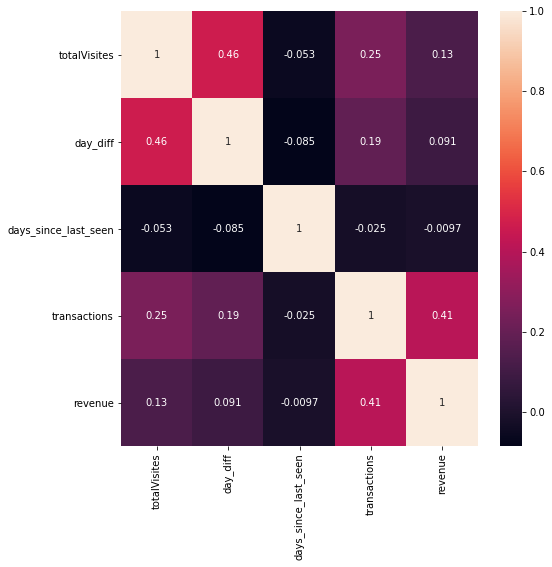

In [21]:
# Correlation 
plt.figure(figsize=(8,8))
sns.heatmap(data=dataset_ml.corr(), annot=True)

In [0]:
#Import Kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [23]:
# Initiate StandarScaler
scaler = StandardScaler()

# Scaler fit transform
dataset_scaler = pd.DataFrame(scaler.fit_transform(dataset_ml) , index=dataset_ml.index, columns=dataset_ml.columns)
dataset_scaler.head()

,totalVisites,day_diff,days_since_last_seen,transactions,revenue
fullVisitorId,,,,,
4984366501121503466,16.394735,17.912791,-1.793801,103.814241,122.076969
6760732402251466726,27.931975,9.191003,0.215896,97.319312,82.532278
2402527199731150932,21.442277,14.587217,-1.190892,97.319312,47.529401
0608915197735218105,11.347192,16.218631,-1.803371,84.329456,41.858233
2074164338647079047,20.000122,5.928176,0.694396,77.834527,2.814311


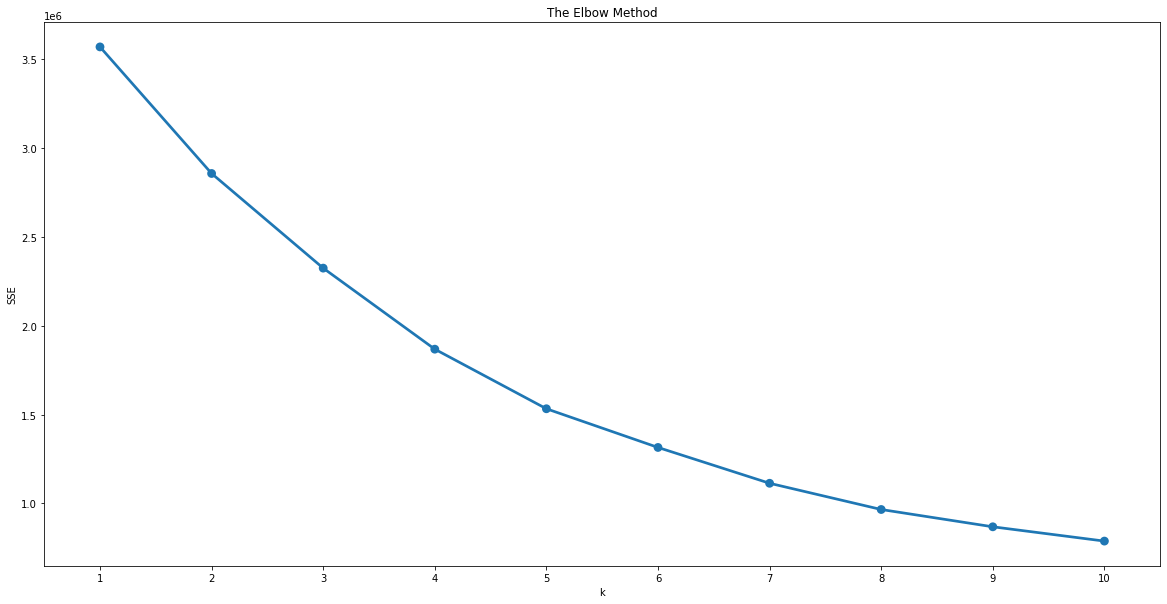

In [24]:
# Elbow Method to find the number of cluster 
sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(dataset_scaler)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_ 
#Size
plt.figure(figsize=(20,10))
# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## Kmeans Clustering


In [0]:
# Kmeans clustering 
kmeans_ = KMeans(n_clusters=4, random_state=1).fit(dataset_scaler)

In [26]:
# Adding cluster label to dataset 
cluster = dataset_ml.merge(pd.DataFrame(kmeans_.labels_, 
                                        index=dataset_scaler.index).rename(columns=({0:'cluster_label'})) 
                                        , right_index=True, left_index=True)
# Summary data with cluster label
cluster.groupby('cluster_label').mean().T

cluster_label,0,1,2,3
totalVisites,1.208621,1.156533,6.725952,3.215324
day_diff,1.184241,0.928180,127.056317,15.396491
days_since_last_seen,243.283234,427.268922,275.580981,327.656665
transactions,0.000000,0.000000,0.058235,1.150125
revenue,0.000000,0.000000,5.469030,167.324047


####Cluster Definition

---
 

*   0 : New Prospect => Visit website recently by didn't buy anything
*   1 : Lost Prospect => Visit website long time ago but didn't buy anything
*   2 : Potential Loyalists => making several visits recently and buy 
*   3 : Champions => Almost buy something everytime they visit the website



2 : Potential Loyalists
3 : Champions

In [0]:
df_cluster=cluster.groupby('cluster_label')['totalVisites'].count().reset_index()
df_cluster['cluster_label'].replace({0:'New Prospect ' ,1:'Lost Prospect',2: 'Potential Loyalist' , 3:'Champions'}, inplace=True)


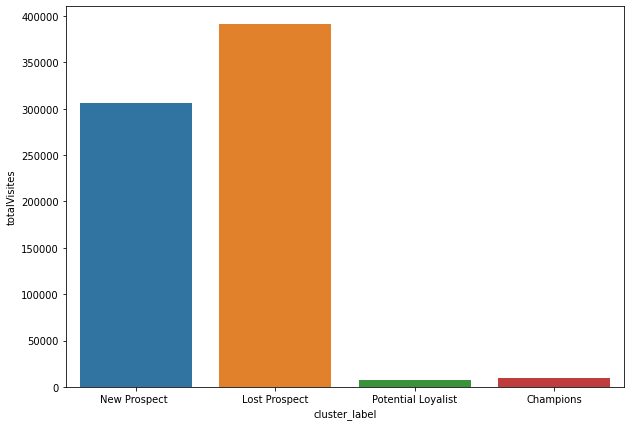

In [37]:

plt.figure(figsize=(10,7))
sns.barplot(data=df_cluster, y='totalVisites', x='cluster_label')

## Dimensional reduction with PCA

In [0]:
# Import PCA from sklearn
from sklearn.decomposition import PCA

# Fit the data with 2 compenent's PCA
pca = PCA(n_components=2)
print(pca.fit_transform(dataset_ml))
print(pca.explained_variance_ratio_)

[[ 3.59891621e+02  9.65494365e+03]
 [ 1.93226788e+02  3.76047052e+03]
 [ 9.34536721e+01  6.52922179e+03]
 ...
 [-5.86201017e+01 -1.32228381e+00]
 [-5.26215671e+01 -1.42858159e+00]
 [-9.36115530e+01 -7.02213432e-01]]
[0.62658298 0.35897002]


In [0]:
pca_data = cluster[['cluster_label']].merge(pd.DataFrame(pca.fit_transform(dataset_ml) , index=dataset_ml.index , columns=['PC1','PC2']), right_index=True, left_index=True )
pca_data.head(10)

,cluster_label,PC1,PC2
fullVisitorId,,,
4984366501121503466,0,359.891621,9654.943645
2402527199731150932,0,193.226788,3760.470521
6760732402251466726,0,93.453672,6529.221788
0608915197735218105,0,249.719120,3311.362093
2074164338647079047,0,-67.355791,225.662458
7311242886083854158,0,321.970491,7198.512756
8197879643797712877,0,236.836144,4075.010017
9089132392240687728,0,315.015417,10045.081237
9029794295932939024,0,285.574467,7896.391843


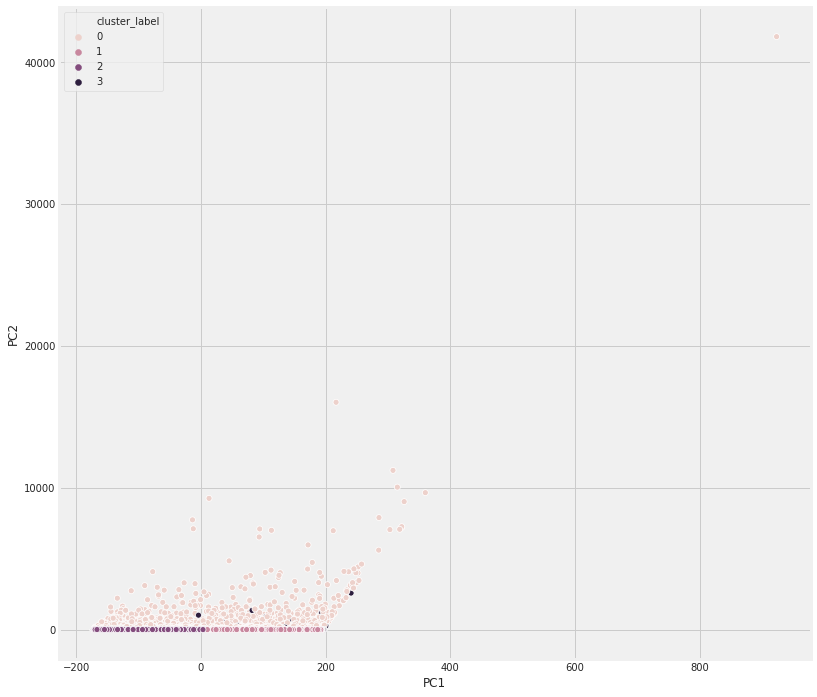

In [0]:
# Scatterplot PCA componets and Cluster
plt.figure(figsize=(12,12)) 
sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='cluster_label')